In [3]:
import operator
import os
from dotenv import load_dotenv
load_dotenv()
from pydantic import BaseModel, Field
from typing import TypedDict, Annotated, Sequence
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.messages import BaseMessage
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain_groq import ChatGroq
from langchain_tavily import TavilySearch
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_community.document_loaders import PyPDFLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter


In [4]:
## Getting Groq API key
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
## Getting TAVILY API key
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
# print(os.getenv("TAVILY_API_KEY"))

EMBEDDING_MODEL = "all-MiniLM-L6-v2"
INFERENCE_MODEL = "gemma2-9b-it"

### Initializing the LLM, Embeddings and the Tavily Web Crawler

In [5]:
llm = ChatGroq(model=INFERENCE_MODEL, temperature=0.3)
# print('--------Creating the response from llm based on contexts--------')

embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)
len(embeddings.embed_query('Hi'))

# Initialize Tavily tool
tavily_tool = TavilySearch(max_results=5, topic="news")


e:\AgenticAI KrishNaikAcademy\Classroom HandsOn\agentic_class_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Initializing the Web Crawler Retriever Function

In [6]:
def web_retriever(query):
    # query = inputs["question"]
    result = tavily_tool.invoke({"query": query})
    snippets = [r["content"] for r in result["results"] if "content" in r]
    # return "\n\n".join(snippets)
    return {"context": "\n\n".join(snippets), "question": query}

### Initializing the RAG

In [7]:
loader = DirectoryLoader("./data", glob="./*.pdf", loader_cls=PyPDFLoader)
docs = loader.load()

In [8]:
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50
)
new_docs=text_splitter.split_documents(documents=docs)

In [9]:
db=Chroma.from_documents(new_docs,embeddings)
retriever=db.as_retriever(search_kwargs={"k": 5})

In [10]:
retriever.invoke("How to capture a Behavior of a wildlife")

[Document(metadata={'source': 'data\\From Snapshots to Great Shots.pdf', 'creationdate': '2011-10-20T17:07:34+05:30', 'total_pages': 38, 'codemantra, llc': 'http://www.codemantra.com', 'producer': 'PyPDF', 'creator': 'Quite Imposing 1.5d (EN)', 'moddate': '2011-12-20T10:28:13-05:00', 'page': 15, 'universal pdf': 'The process that creates this PDF constitutes a trade secret of codeMantra, LLC and is protected by the copyright laws of the United States', 'title': 'Wildlife Photography: From Snapshots to Great Shots', 'author': 'Laurie Excell', 'page_label': '6'}, page_content='wildlife behavior \nwith narration \nexplaining it at the \nsame time.'),
 Document(metadata={'total_pages': 31, 'trapped': '/False', 'page': 29, 'source': 'data\\The Art of Wildlife Photography.pdf', 'producer': 'Adobe PDF Library 15.0', 'moddate': '2019-11-29T14:01:41+10:00', 'creator': 'Adobe InDesign 15.0 (Macintosh)', 'creationdate': '2019-11-29T14:01:35+10:00', 'page_label': '30'}, page_content='acting natura

### Creating the Pydantic Output Parser

In [11]:
class TopicSelectionParser(BaseModel):
    Topic: str=Field(description="Selected Topic")
    Reasoning: str=Field(description="Reasoining behind topic selection")

In [12]:
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "Selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoining behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

### Creating the State Schema

In [13]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

### Node Functions

In [26]:
def function_supervisor(state:AgentState):
    print("-> Inside Supervisor Function <-")
    question = state["messages"][-1]
    print(f"Question: {question}")

    template = """
    Your task is to classify the user's query into one of the following categories: [Unrelated, Wildlife Photography, real-time info]
    only respond with the category name and nothing more than that.

    User Query: {question}
    {format_output}
    """

    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_output":parser.get_format_instructions()}
    )

    chain = prompt | llm | parser
    response = chain.invole(prompt)

    print("Parsed response", response)

    return {"messages": [response.Topic]}

def function_llm(state:AgentState):
    print("-> Inside LLM Node <-")
    question = state["messages"][0]
    
    # Normal LLM call
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def function_rag(state:AgentState):
    print("-> Inside RAG Node <-")
    question = state["messages"][0]

    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context from internet to answer the question. If you don't know the answer, just say that you don't know. \nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )

    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {"messages": [result]}

def function_web_crawl(state:AgentState):
    print("-> Inside Web Crawler <-")
    question = state["messages"][0]

    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context from internet to answer the question. If you don't know the answer, just say that you don't know. \nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )

    web_crawl_chain = (
        RunnableLambda(web_retriever)
        | prompt
        | llm
        | StrOutputParser()
    )
    result = web_crawl_chain.invoke(question)
    return  {"messages": [result]}

def function_validation(state:AgentState):
    pass

In [15]:
state={"messages":["How to capture a Behavior of a wildlife?"]}
function_rag(state)

-> Inside RAG Node <-


{'messages': ['The text suggests that patience is key to capturing wildlife behavior.  \n\nIt states: "If you enjoy photographing wildlife and are looking to capture behaviour shots, one of the most important things to remember is patience. After 23 years of wildlife photography, I have spent hours, days and even weeks (often sitting in a confined, camouflaged hide), waiting for THE moment to press the shutter button." \n\n\nIt also emphasizes minimizing impact on the wildlife and their environment. \n']}

In [16]:
state={"messages":["What happened in the UEFA Nations League 2025 final?"]}
function_web_crawl(state)

-> Inside Web Crawler <-


{'messages': ['After a thrilling match ended in a 2-2 draw, Portugal defeated Spain in a penalty shootout to bring home the 2024-25 Nations League trophy.  \n']}

In [17]:
def format_docs(docs):
    return "\n\n".join(doc['content'] for doc in docs)

In [18]:
# Normal LLM call
complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + "What happened in the UEFA Nations League final?"
response = llm.invoke(complete_query)
print({"messages": [response.content]})

{'messages': ["The UEFA Nations League final took place on **July 18, 2023**, at the **Estádio do Dragão in Porto, Portugal**. \n\n**Spain** defeated **England** **1-0** to win their first-ever UEFA Nations League title. \n\nThe winning goal was scored by **Olmo** in the 16th minute. \n\n\nLet me know if you'd like more details about the match! \n"]}


### Router Function

In [ ]:
def function_router(state:AgentState):
    print("-> Inside Router <-")

    last_message = state["messages"][-1]
    print(f"last_message: {last_message}")

    if "photography" in last_message.lower():
        return "RAG Call"
    elif "llm" in last_message.lower():
        return "LLM Call"
    else:
        return "Web Crawler Call"

In [30]:
from langgraph.graph import StateGraph, END
workflow = StateGraph(AgentState)
workflow.add_node('Supervisor', function_supervisor)
workflow.add_node('RAG', function_rag)
workflow.add_node('LLM', function_llm)
workflow.add_node('Web Crawler', function_web_crawl)
workflow.add_node("Output Validation", function_validation)
workflow.set_entry_point('Supervisor')
workflow.add_conditional_edges(
    'Supervisor',
    function_router,
    {
        "RAG Call":"RAG",
        "LLM Call":"LLM",
        "Web Crawler Call":"Web Crawler"
    }
)
workflow.add_edge("RAG", "Output Validation")
workflow.add_edge("LLM", "Output Validation")
workflow.add_edge("Web Crawler", "Output Validation")
workflow.set_finish_point("Output Validation")
app = workflow.compile()

### View Workflow Diagram

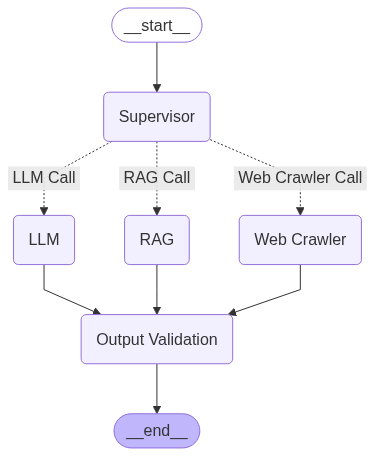

In [32]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))